In [1]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Project 2: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: Monday 11/30, 11:59 PM PST

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset– the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

## Disclaimer about `sns.distplot()`

This project was designed for a slightly older version of seaborn, which does not support the new `displot` method taught in Lecture 9. Instead, in this project will occasionally call `distplot` (with a `t`). As you may have noticed in several of the previous assignments, use of the `distplot` function triggers a deprecation warning to notify the user that they should replace all deprecated functions with the updated version. Generally, warnings should not be suppressed but we will do so in this assignment to avoid cluttering.

See the seaborn documentation on [distributions](https://seaborn.pydata.org/tutorial/distributions.html) and [functions](https://seaborn.pydata.org/tutorial/function_overview.html) for more details.

In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 1
1c | 2
2 | 3
3a | 2
3b | 2
4 | 2
5 | 2
6a | 1
6b | 1
6c | 2
6d | 2
6e | 1
6f | 3
7 | 6
8 | 6
9 | 3
10 | 15
Total | 55

# Part I - Initial Analysis

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [4]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Sun Nov 22 17:15:58 2020
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Sun Nov 22 17:16:00 2020
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [5]:
original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [6]:
null_in_e = pd.isna(original_training_data["spam"]).value_counts()
null_in_e

False    8348
Name: spam, dtype: int64

In [7]:
null_in_s = pd.isna(original_training_data["subject"]).value_counts()[1]
#null_in_e = pd.isna(original_training_data["email"]).value_counts()[1]
#null_in_spam = d.isna(original_training_data["spam"]).value_counts()[1]
null_in_s

6

In [8]:
original_training_data["subject"] = original_training_data["subject"].fillna("")

In [9]:
grader.check("q1a")

All tests passed!

### Question 1b

In the cell below, print the text of the `email` field for the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [10]:
first_ham = original_training_data.iloc[0, :]["email"]
first_spam = original_training_data.iloc[2, :]["email"]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [11]:
grader.check("q1b")

All tests passed!

<!-- BEGIN QUESTION -->

### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->

The first email is a proper email with a body text, while the second email is in the format of html tags that don't seem to indicate a proper text.

<!-- END QUESTION -->



## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [12]:
# This creates a 90/10 train-validation split on our labeled data

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [13]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for i in texts:
        temp = []
        for j in words:
            if j in i:
                temp.append(1)
            else:
                temp.append(0)
        indicator_array.append(temp)
    return np.array(indicator_array)

In [14]:
words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

In [15]:
grader.check("q2")

All tests passed!

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](images/training_conditional_proportions.png)

You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [16]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column."))
display(df.melt("type"))

> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


In [17]:
train.head(15)

,id,subject,email,spam
7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0
6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0
6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0
4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0
5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0
5247,5247,Subject: asap\n,--===_secatt_000_1fuklemuttfusq\n content-type...,1
7410,7410,Subject: [use Perl] Headlines for 2002-09-18\n,use perl daily headline mailer\n \n subscribe ...,0
576,576,"Subject: Cost price Guinness, Budweiser and se...",------=_part_2067_1947928.1038245405702\n cont...,0
4398,4398,Subject: Play by Play: Effective Memory Manage...,"url: http://www.newsisfree.com/click/-0,861367...",0
3989,3989,Subject: Sheila Lennon was interviewed for the...,url: http://scriptingnews.userland.com/backiss...,0


<!-- BEGIN QUESTION -->

### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->

In [18]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
words = ["url", "hi", "nice", "#", "boing", "<head>"]
word_counts = words_in_texts(words, train["email"])
my_data = pd.DataFrame(word_counts)
my_data.insert(6, "type", train["spam"])
#my_data = my_data.groupby("type").agg(sum)
my_data = my_data.rename(columns={0: "url", 1: "hi", 2:"nice", 3:"#", 4:"boing", 5:"<head>"})
my_data["type"] = my_data["type"].replace(0, "Ham")
my_data["type"] = my_data["type"].replace(1, "Spam")
my_data = my_data.melt("type")
my_data

,type,variable,value
0,Ham,url,0
1,Ham,url,1
2,Ham,url,0
3,Ham,url,0
4,Ham,url,1
...,...,...,...
45073,Ham,<head>,0
45074,Spam,<head>,0
45075,Ham,<head>,0
45076,Ham,<head>,0


Text(0.5, 1.0, 'Frequency of Words in Spam/Ham Emails')

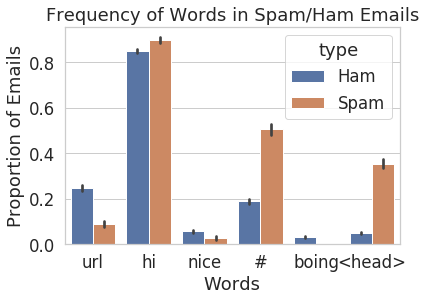

In [19]:
sns.barplot(x="variable", y = my_data["value"], hue=my_data["type"], data=my_data)
plt.xlabel("Words")
plt.ylabel("Proportion of Emails")
plt.title("Frequency of Words in Spam/Ham Emails")

<!-- END QUESTION -->



When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

<!-- BEGIN QUESTION -->

### Question 3b

![training conditional densities](images/training_conditional_densities.png)

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->

In [20]:
ham = train[train["spam"] == 0]
spam = train[train["spam"] == 1]
len(spam["email"].iloc[0])
spam["length"] = [len(spam["email"].iloc[i]) for i in range(len(spam["email"]))]
ham["length"] = [len(ham["email"].iloc[i]) for i in range(len(ham["email"]))]

<ipython-input-20-9afb3b9c35ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam["length"] = [len(spam["email"].iloc[i]) for i in range(len(spam["email"]))]
<ipython-input-20-9afb3b9c35ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ham["length"] = [len(ham["email"].iloc[i]) for i in range(len(ham["email"]))]


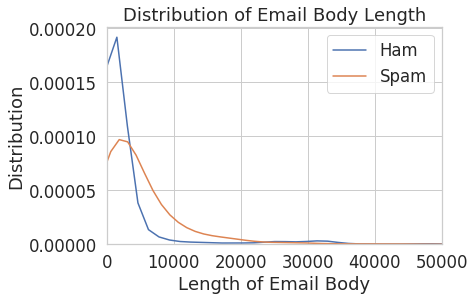

In [21]:
sns.distplot(ham["length"], hist=False, label="Ham")
sns.distplot(spam["length"], hist=False, label="Spam")
plt.xlim(0, 50000)
plt.legend()
plt.title("Distribution of Email Body Length")
plt.xlabel("Length of Email Body")
plt.ylabel("Distribution")
plt.savefig('training_conditional_densities.png')

<!-- END QUESTION -->



# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of only 0's and 1's). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [22]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train["email"])
Y_train = train["spam"]

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [23]:
grader.check("q4")

All tests passed!

### Question 5

Now that we have matrices, we can build a model with `scikit-learn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.75$

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = np.mean(model.predict(X_train) == Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [25]:
grader.check("q5")

All tests passed!

## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The two graphics below may help you understand precision and recall visually:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (feel free to hard code your answers for this part):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [26]:
Y_train

0       0
1       0
2       0
3       0
4       0
       ..
7508    0
7509    1
7510    0
7511    0
7512    0
Name: spam, Length: 7513, dtype: int64

In [27]:
#Y_pred = model.predict(X_train)
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train == 1)
zero_predictor_fp, zero_predictor_fn

(0, 1918)

In [28]:
grader.check("q6a")

All tests passed!

### Question 6b

What is the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [29]:
zero_predictor_acc = np.mean(Y_train == 0)
zero_predictor_recall = 0
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0)

In [30]:
grader.check("q6b")

All tests passed!

<!-- BEGIN QUESTION -->

### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

The FP value is 0 because the zero-predictor will only ever predict emails as ham. The FN value is so high because this predictor labels all email as ham, such that actual spam emails will also get labelled as ham such that the false negative rate becomes very high. Accuracy is relatively high because many emails are ham more often than spam -- classifying all emails as ham would thus technically result in a decent accuracy rate. Recall value is 0 because the TP rate is 0. 

<!-- END QUESTION -->

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [31]:
Y_pred = model.predict(X_train)
tp = np.sum((Y_pred == 1) & (Y_train == 1))
tn = np.sum((Y_pred == 0) & (Y_train == 0))
fp = np.sum((Y_pred == 1) & (Y_train == 0))
fn = np.sum((Y_pred == 0) & (Y_train == 1))
logistic_predictor_precision = tp / (tp+fp)
logistic_predictor_recall = tp / (tp+fn)
logistic_predictor_far = fp / (fp+tn)

In [32]:
grader.check("q6d")

All tests passed!

In [33]:
fp, fn

(122, 1699)

<!-- BEGIN QUESTION -->

### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->

There are much more false negatives when using the logistic regression classifier. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

1. Our logistic regression classifier got 75.76% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->

1. The logistic regression classifier performed only slightly better than the zero predictor.
2. The words provided are not very prevalent in the email set--this makes it such that the data we are working with to construct the model is limited, such that the model isn't trained with a wide variety of data points to perform better.
3. I would prefer the zero predictor classifier as opposed to the logistic regression classifier, because the recall rate for the zero predictor classifier is much higher. This is because the logistic regression classifier has a very high false negative rate. Recall measures the the proportion of spam emails that were correctly flagged as spam, so having a higer recall rate would be much more helpful in filtering out spam emails. 

<!-- END QUESTION -->



# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

**Gradescope limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on 70% of the test set when submitting to Gradescope, but we will be evaluating your model on the entire test set so try to score slightly above 88% on gradescope if you can.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set.* Note, however, that you may overfit to your validation set if you try to optimize your validation accuracy too much.

---

In [34]:
train[train["email"].str.contains("requested")]["spam"].value_counts()

1    41
0    22
Name: spam, dtype: int64

In [ ]:
my_words = ["loan", "!!!!", "discount", "<html>", "<head>", "coupon", 
            "big money", "adults", "<body>", "<center>", "porn", "sex", 
            "<p>", "<script>", "<title>", "<div", "<img", "</head>", "<tr", "><img", 
            "</head>", "<table", "<br>", "</font>", "</td>", "<a", "free", "shipping", 
            "available", "online", "pills", "viagra", "erectile", "meds", "dysfunction",
           "cialis", "trial", "performance", "here", "best", "hard", "buy", "today!",
           "shipping", "monthly", "TODAY", "cheap", "now", "!!!!!!!!!!!!", "great", "apply now",
           "apply", "affordable", "certified", "refund", "trial", "order now", 
           "limited", "terms", "offer", "rates", "score", "success", "luxury", "money", "hello", "price",
           "dear", "cash", "guaranteed", "amazing", "get it now", "deals", "clearance", "final", "earn",
           "biz", "$$$", "claim", "quote", "save", "invest", "investment", "stock", "chance", "satisfaction", "click",
           "remove", "sales", "pharmacy", "million", "obligation", "warranty", "win", "winner", "preview", "sample",
           "instant", "lifetime", "legal", "100%", "bonus","full refund", "incredible", "miracle", "prize", "special",
           "call now", "text", "sign", "urgent", "supplies", "sir", "weight", "weight loss", "#1", "credit", "50%",
           "act now", "action", "call", "ad", "accept", "cancel", "collect", "exclusive", "expire", "give away", 
            "assets", "requested"]
x_tr = words_in_texts(my_words, val["email"])
y_tr = val["spam"]
m = LogisticRegression(random_state=42)
m.fit(x_tr, y_tr)
y_pred = m.predict_proba(x_tr)[:, 1]
my_acc = np.mean(m.predict(x_tr) == y_tr)
my_acc

<!-- BEGIN QUESTION -->

### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->

1. I used words that one would typically find in a spam email. I tried to use words that had a high prevalence in spam emails over ham emails via using value_counts() in both the training and validation data, or found common words found in typical spam emails, and once I found the prevalence to be high enough to positively influence the performance of the model, I added that word to my_list. 

2. I tried a multitude of things -- I created different functions that (1) checked whether an email was a reply email or not (2) contained a high number of exclamation points and (3) was all lowercase letters or not. I tried to combine these feature functions together by calling &, but that did not work to my advantage. So, I tried to create my_words_in_texts to combine the feature of finding certain words in email bodies as well as classifying whether an email was a reply email or not, yet using this function over the words_in_texts function proved to be inefficient. Thus, I ended up going with the words_in_texts function to maximize accuracy.

3. I found it surprising that words that one might deem to be very "spammy" were not necessarily so i.e. "free" was a word I expected to have a high prevalence in spam emails, but had almost the same prevalence in both spam and ham emails. 

<!-- END QUESTION -->



### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. 

Include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel free to create as many plots as you want in your process of feature selection, but select only one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

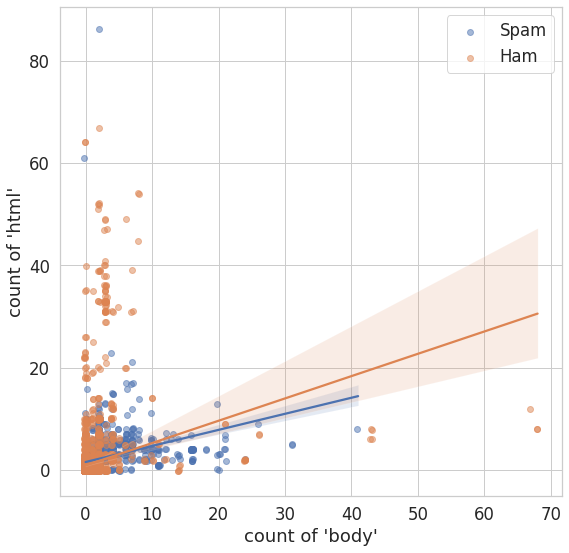

In [135]:
# In plotting the co-occurrence of "body" and "html", I found that they do indeed occur together frequently as seen by
# the large cluster of points in the left-hand bottom corner.
# We can notice that the variance of "html" is higher in ham emails than spam emails. 
# Additionally, we notice that there is a higher count of "body" in their email body content -- this makes sense as
# the word "body" can be found not only in html tags but also in normal dialogue, whereas it is much less likly for 
# the word "html" to appear outside of html tags.



def html_redundancy(df, tag):
    return df["email"].str.findall(tag).str.len()

spam = train[train["spam"] == 1]
ham = train[train["spam"] == 0]

plt.figure(figsize=(9, 9))
p = sns.regplot(x=html_redundancy(spam, "body"), y=html_redundancy(spam, "html"), 
                x_jitter=0.2, y_jitter=0.2, label="Spam", scatter_kws={"alpha":0.5})

p = sns.regplot(x=html_redundancy(ham, "body"), y=html_redundancy(ham, "html"), 
                x_jitter=0.2, y_jitter=0.2, label="Ham", scatter_kws={"alpha":0.5})


plt.xlabel("count of 'body'")
plt.ylabel("count of 'html'")
p.legend()

<!-- BEGIN QUESTION -->

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->

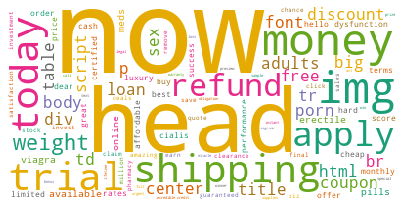

In [136]:
# Write your description (2-3 sentences) as a comment here:
# Here, I plotted a wordcloud of the word features I used in fitting the model via the words_in_texts function.
# This word cloud depicts the relative frequency of what features were most found amongst email bodies.
# Here, we observe that the words "head" and "now" appear more frequently than some other words that were used
# as features.

# Write the code to generate your visualization here:
from wordcloud import WordCloud

string = ' '.join(my_words)

cloud = WordCloud(background_color = "white", 
                  colormap = "Dark2", max_font_size=120, random_state=42).generate(string)

plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(cloud)
plt.axis("off")
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 9: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. Refer to Lecture 19 or [Section 17.7](https://www.textbook.ds100.org/ch/17/classification_sensitivity_specificity.html) of the course text to see how to plot an ROC curve.

<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Text(0.5, 1.0, 'Different Positive Rates')

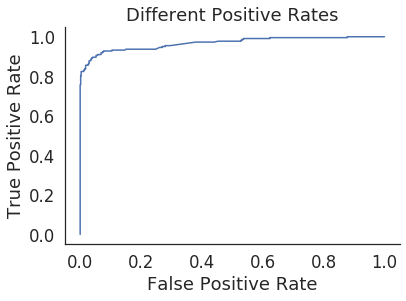

In [137]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

m9 = LogisticRegression(penalty="none", solver="saga")
m9.fit(x_tr, y_tr)

model_probabilities = m9.predict_proba(x_tr)[:, 1]
fp, tp, thresholds = roc_curve(y_tr, model_probabilities)
with sns.axes_style("white"):
    plt.plot(fp, tp)
    
sns.despine()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Different Positive Rates")

<!-- END QUESTION -->

# Question 10: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Project 2 Test Predictions" assignment on Gradescope to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions`. **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

**Note: You may submit up to 4 times a day. If you have submitted 4 times on a day, you will need to wait until the next day for more submissions.**

Note that this question is graded on an absolute scale based on the accuracy your model achieves on the overall test set, and as such, your score does not depend on your ranking on Gradescope. Your public Gradescope results are based off of your classifier's accuracy on 70% of the test dataset and your score for this question will be based off of your classifier's accuracy on 100% of the test set.

*The provided tests check that your predictions are in the correct format, but you must additionally submit to Gradescope to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 3
-->

In [142]:
x_tr2 = words_in_texts(my_words, test["email"])
#y_tr = test["spam"]

#m = LogisticRegression(random_state=42)
#m.fit(x_tr, y_tr)
#np.mean(m.predict(x_tr) == y_tr)

#cv2 = CountVectorizer()
#vectorized2 = cv.fit_transform(test["email"])
#x_tr2, y_tr2 = train_test_split(vectorized2, shuffle=False)

#m = LogisticRegression()
#m.fit(x_tr2[0], y_tr2[0])

test_predictions = m.predict(x_tr2)

In [143]:
grader.check("q10")

All tests passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project 2 Test Predictions" assignment on Gradescope to get credit for this question.**

In [140]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Gradescope for scoring.')

Created a CSV file: submission_2020-11-30T19:41:15.csv.
You may now upload this CSV file to Gradescope for scoring.


---

To double-check your work, the cell below will rerun all of the autograder tests.

In [141]:
grader.check_all()

q10:

    All tests passed!
    

q1a:

    All tests passed!
    

q1b:

    All tests passed!
    

q2:

    All tests passed!
    

q4:

    All tests passed!
    

q5:

    All tests passed!
    

q6a:

    All tests passed!
    

q6b:

    All tests passed!
    

q6d:

    All tests passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [111]:
# Save your notebook first, then run this cell to export your submission.
grader.export("proj2.ipynb")